In [9]:
import pandas as pd
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer

In [10]:
df = pd.read_csv("propaganda_results.csv")
prop_df = df[(df["is_propaganda"] == True) & (df["prop_score"] > 0.9)].copy()

def map_year_group(year):
    if year == 1999 or year == 2000:
        return "1999_2000"
    elif year == 2008 or year == 2009:
        return "2008_2009"
    elif year == 2023 or year == 2024:
        return "2023_2024"
    else:
        return str(year)

prop_df["year_group"] = prop_df["year"].apply(map_year_group)

grouped_df = prop_df.drop(columns=["year"]).rename(columns={"year_group": "year"})

grouped_df.head()

,sentence,prop_label,prop_score,is_propaganda,year
11,"However, it is clear already now that it was t...",has_propaganda,0.912558,True,1999_2000
30,I would like to welcome them on behalf of the ...,has_propaganda,0.959487,True,1999_2000
59,But after a pause Mr Yeltsin returned to the s...,has_propaganda,0.963755,True,1999_2000
75,We should treat our parents the way we want ou...,has_propaganda,0.917321,True,1999_2000
87,And the parting words – and at that point I ne...,has_propaganda,0.924881,True,1999_2000


In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

device = 'mps' if torch.backends.mps.is_available() else 'cpu'

embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)
vectorizer_model = CountVectorizer(stop_words="english")
topic_model = BERTopic(embedding_model=embedding_model, vectorizer_model=vectorizer_model, calculate_probabilities=True)

sentences = grouped_df["sentence"].tolist()
embeddings = np.array(embedding_model.encode(sentences, show_progress_bar=False))
topics, probs = topic_model.fit_transform(sentences, embeddings)
grouped_df["topic"] = topics

lemmatizer = WordNetLemmatizer()
year_groups = sorted(grouped_df["year"].unique())
output_rows = []

for yg in year_groups:
    year_df = grouped_df[grouped_df["year"] == yg]
    if len(year_df) == 0:
        continue

    topic_counts = year_df["topic"].value_counts()
    topics_sorted = [t for t in topic_counts.index if t != -1]  
    top_topic = topics_sorted[0] if topics_sorted else -1

    count = topic_counts.get(top_topic, 0)
    words = [w for w,_ in topic_model.get_topic(top_topic)] if top_topic != -1 else []

    unique_words = []
    for w in words:
        lemma = lemmatizer.lemmatize(w.loower())
        if lemma not in [lemmatizer.lemmatize(uw.lower()) for uw in unique_words]:
            unique_words.append(w)
        if len(unique_words) == 3:
            break
    label = " ".join(unique_words) if unique_words else "(outlier)"

    rep_sentences = year_df[year_df["topic"] == top_topic]["sentence"].tolist()[:3]

    output_rows.append({
        "year_group": yg,
        "topic_id": top_topic,
        "topic_label": label,
        "num_sentences": count,
        "representative_sentences": rep_sentences
    })

out_df = pd.DataFrame(output_rows)
out_df.to_csv("propaganda_top_topic_per_year_group_final1.csv", index=False)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/leniecka/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/leniecka/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


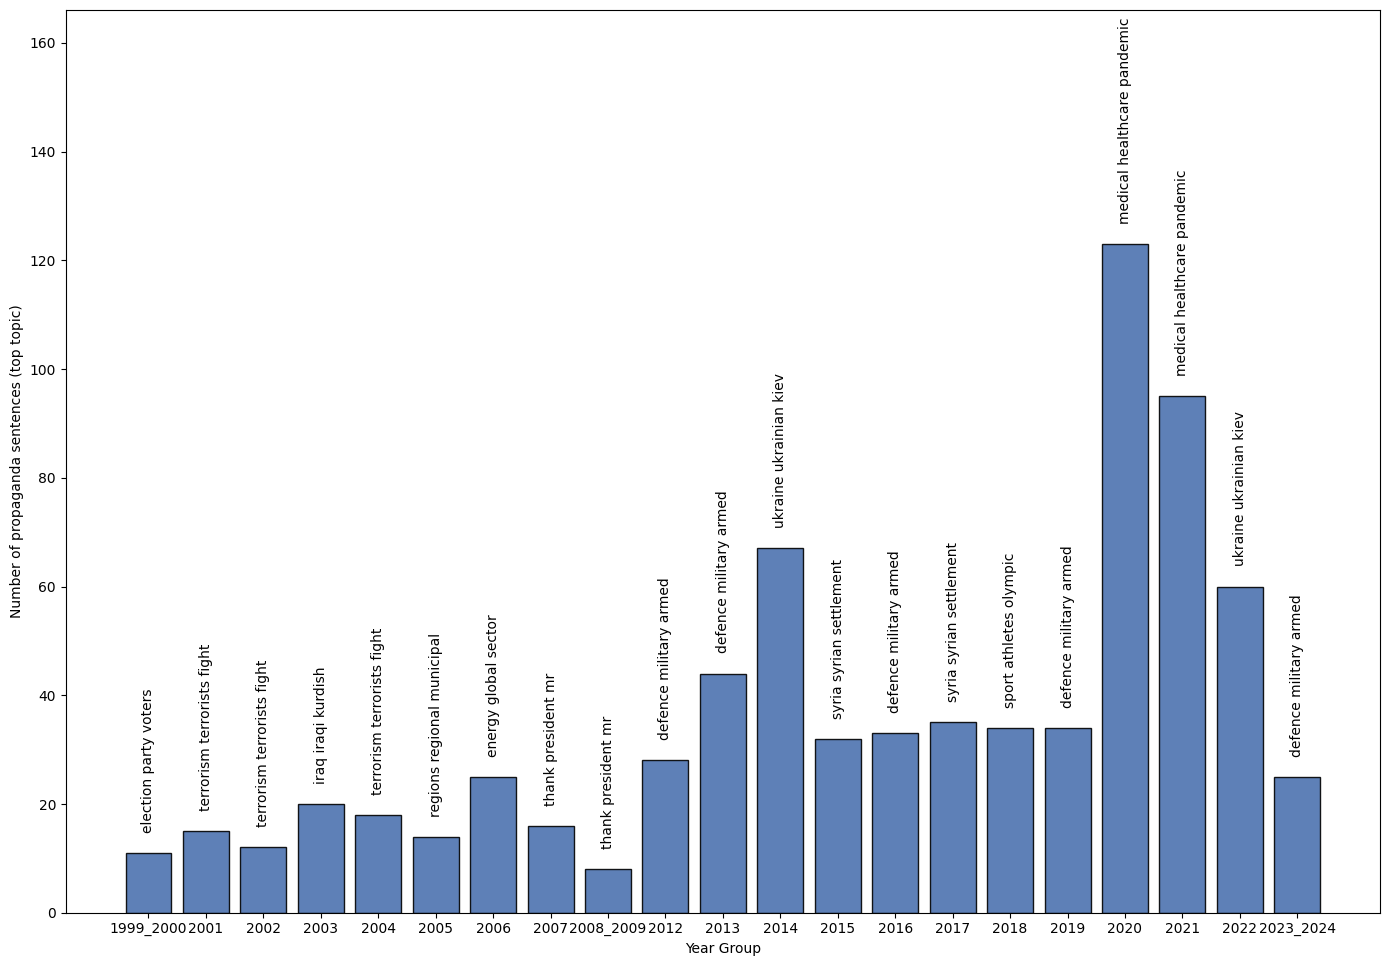

In [ ]:
out_df = pd.read_csv("propaganda_top_topic_per_year_group100.csv")

plt.figure(figsize=(14,10))

bars = plt.bar(
    range(len(out_df)),
    out_df["num_sentences"],
    color="#4C72B0",     
    edgecolor="black",
    alpha=0.9
)

plt.xticks(range(len(out_df)), out_df["year_group"], rotation=0)
plt.ylabel("Number of propaganda sentences (top topic)")
plt.xlabel("Year Group")

y_max = out_df["num_sentences"].max()
plt.ylim(0, y_max * 1.35)

for bar, label in zip(bars, out_df["topic_label"]):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + y_max * 0.03,
        label,
        ha="center",
        va="bottom",
        rotation=90,
        fontsize=10
    )

plt.tight_layout()
plt.show()